# Segmenting Lung X-ray Images with the Segment Anything Model
### Advanced Deep Learning 2022
Notebook written by [Jakob Ambsdorf](mailto:jaam@di.ku.dk).
Lung x-ray code originally written by Mathias Perslev. It has been changed slightly by Christian Igel and subsequently slightly updated [Stefan Sommer](mailto:sommer@di.ku.dk).
SAM related code (c) Meta Platforms, Inc. and affiliates.

We consider the data described in:
Bram van Ginneken, Mikkel B. Stegmann, Marco Loog. [Segmentation of anatomical structures in chest radiographs using supervised methods: a comparative study on a public database](https://doi.org/10.1016/j.media.2005.02.002). *Medical Image Analysis* 10(1): 19-40, 2006

## Object masks from prompts with SAM

The Segment Anything Model (SAM) predicts object masks given prompts that indicate the desired object. The model first converts the image into an image embedding that allows high quality masks to be efficiently produced from a prompt.

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [2]:
using_colab = False

In [3]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

## Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [5]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


# Download model checkpoint
The checkpoint is 2.39GB, takes a few minutes for most bandwidths

In [6]:
import urllib.request
import os
from tqdm import tqdm

url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
filename = "sam_vit_h_4b8939.pth"
folder = "models"

os.makedirs(folder, exist_ok=True)

filepath = os.path.join(folder, filename)

if not os.path.exists(filepath):
    # Get the file size before downloading
    file_size = int(urllib.request.urlopen(url).info().get("Content-Length", -1))

    # Start the download with progress bar
    with tqdm(unit="B", unit_scale=True, unit_divisor=1024, total=file_size, desc=filename, ncols=80) as pbar:
        urllib.request.urlretrieve(url, filepath, reporthook=lambda b, bsize, t: pbar.update(bsize))
else:
    print("Checkpoint file already exists. Skipping download.")

Checkpoint file already exists. Skipping download.


In [7]:
#import sys
#sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "models/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

c:\Users\chris\anaconda3\Lib\site-packages\segment_anything\build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


# Chest X-ray Dataset

In [8]:
import os
from torchvision.datasets.utils import download_url

In [9]:
# Mount Google drive
try:
    from google.colab import drive
    drive.mount('/content/gdrive/')
    os.chdir('gdrive/MyDrive/ADL2022')
except:
    print('Google drive not mounted')

Google drive not mounted


In [10]:
# If you are getting a download error, comment in the following lines:
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

In [11]:
# Load database with chest X-rays with lung segmentations.
data_root='./datasets'
data_npz='lung_field_dataset.npz'
data_fn = os.path.join(data_root, "lung_field_dataset.npz")
force_download = False

if (not os.path.exists(data_fn)) or force_download:
    download_url("https://sid.erda.dk/share_redirect/gCTc6o3KAh", data_root, data_npz)
else:
    print('Using existing', data_fn)

Using existing ./datasets\lung_field_dataset.npz


In [12]:
def plot_image_with_segmentation(image, segmentation, ax=None):
    """
    Plots an image with overlayed segmentation mask

    Returns: plt.fig and ax objects
    """
    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)
        ax.axis("off")

    ax.imshow(image.squeeze(), cmap="gray")
    mask = np.ma.masked_where(segmentation == 0, segmentation)
    ax.imshow(mask.squeeze(), cmap="Set1", alpha=0.5)
    return plt.gcf(), ax


def load_npz_dataset(path, keys=('x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test')):
    archive = np.load(path)
    return [archive.get(key) for key in keys]

In [13]:
def map_interval(image, from_min, from_max, to_min, to_max):
    """
    Map values from [from_min, from_max] to [to_min, to_max]
    """
    from_range = from_max - from_min
    to_range = to_max - to_min
    # scaled = np.array((image - from_min) / float(from_range), dtype=float)
    scaled = (image - from_min) / float(from_range)
    return to_min + (scaled * to_range)

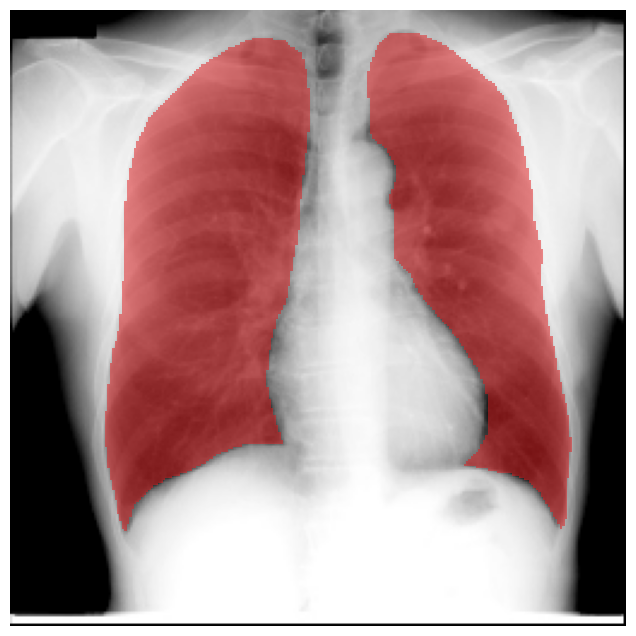

In [ ]:
import numpy as np

# Load train/val/test data
x_train, y_train, x_val, y_val, x_test, y_test = load_npz_dataset(data_fn)

# Bringing images into the correct format for SAM:
x_train = (255 * (x_train - np.min(x_train)) / (np.max(x_train) - np.min(x_train)))
x_val = (255 * (x_val - np.min(x_val)) / (np.max(x_val) - np.min(x_val)))
x_test = (255 * (x_test - np.min(x_test)) / (np.max(x_test) - np.min(x_test)))

x_train = np.repeat(x_train, 3, axis=-1).astype(np.uint8)
x_val = np.repeat(x_val, 3, axis=-1).astype(np.uint8)
x_test = np.repeat(x_test, 3, axis=-1).astype(np.uint8)

y_train = np.squeeze(y_train).astype(np.uint8)
y_val = np.squeeze(y_val).astype(np.uint8)
y_test = np.squeeze(y_test).astype(np.uint8)


# your data should pass the following asserts
assert x_train.shape == (112, 256, 256, 3)
assert y_train.shape == (112, 256, 256)
assert x_val.shape == (12, 256, 256, 3)
assert y_val.shape == (12, 256, 256)
assert x_test.shape == (123, 256, 256, 3)
assert y_test.shape == (123, 256, 256)

assert x_train.dtype == y_train.dtype == np.uint8
assert np.min(x_train) == 0
assert np.max(x_train) == 255

# Plot an example
fig, ax = plot_image_with_segmentation(x_train[0], y_train[0])
plt.show()

# Single Example image

Let's try to run SAM on a single example image

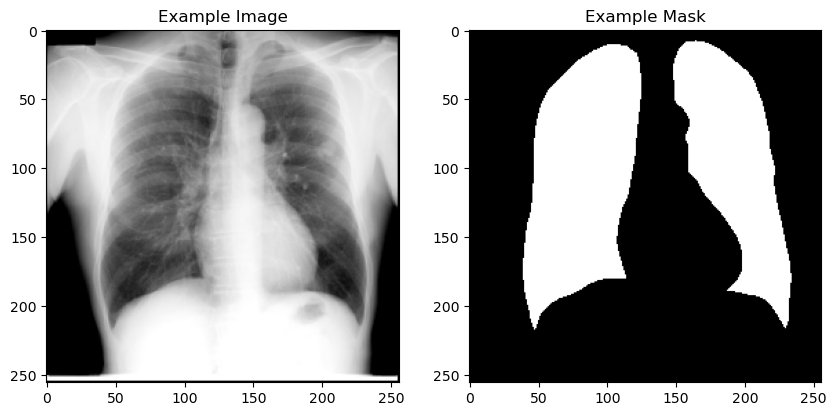

In [ ]:
import matplotlib.pyplot as plt

# Select an example image and mask
example_img, example_mask = x_train[0], y_train[0]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(example_img)
ax[0].set_title('Example Image')
ax[1].imshow(example_mask, cmap='gray')
ax[1].set_title('Example Mask')
plt.show()


In [33]:
example_img, example_mask = x_train[0], y_train[0]

input_points =  np.array([
    [90, 100], 
    [75, 175],
    [100, 50],
    [220, 175],
    [190, 100],
    [180, 70],
    [180, 155]
])

input_label = np.array([1, 1, 1, 1, 1, 1,0])

example_img.shape

(256, 256, 3)

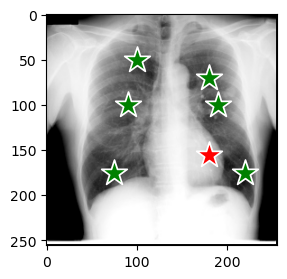

In [34]:
plt.figure(figsize=(3,3))
plt.imshow(example_img)
show_points(input_points, input_label, plt.gca()) # You may also use other prompt methods!
plt.axis('on')
plt.show()

In [40]:
predictor.set_image(example_img)

masks, scores, logits = predictor.predict(
    point_coords=input_points,
    point_labels=input_label,
    multimask_output=True,
)

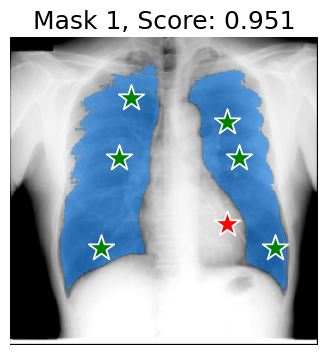

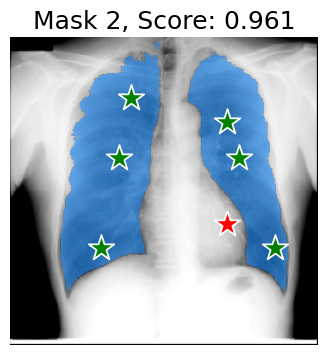

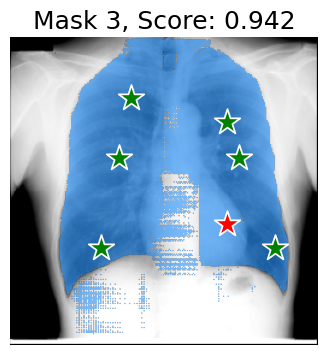

In [41]:
# Note that the "score" here is an estimation of the mask quality, not the quality of the segmentation compared to the ground truth.
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(4,4))
    plt.imshow(example_img.squeeze())
    show_mask(mask, plt.gca())
    show_points(input_points, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

# Evaluation loop

Mean F1 score: 0.9064
Standard deviation: 0.0215


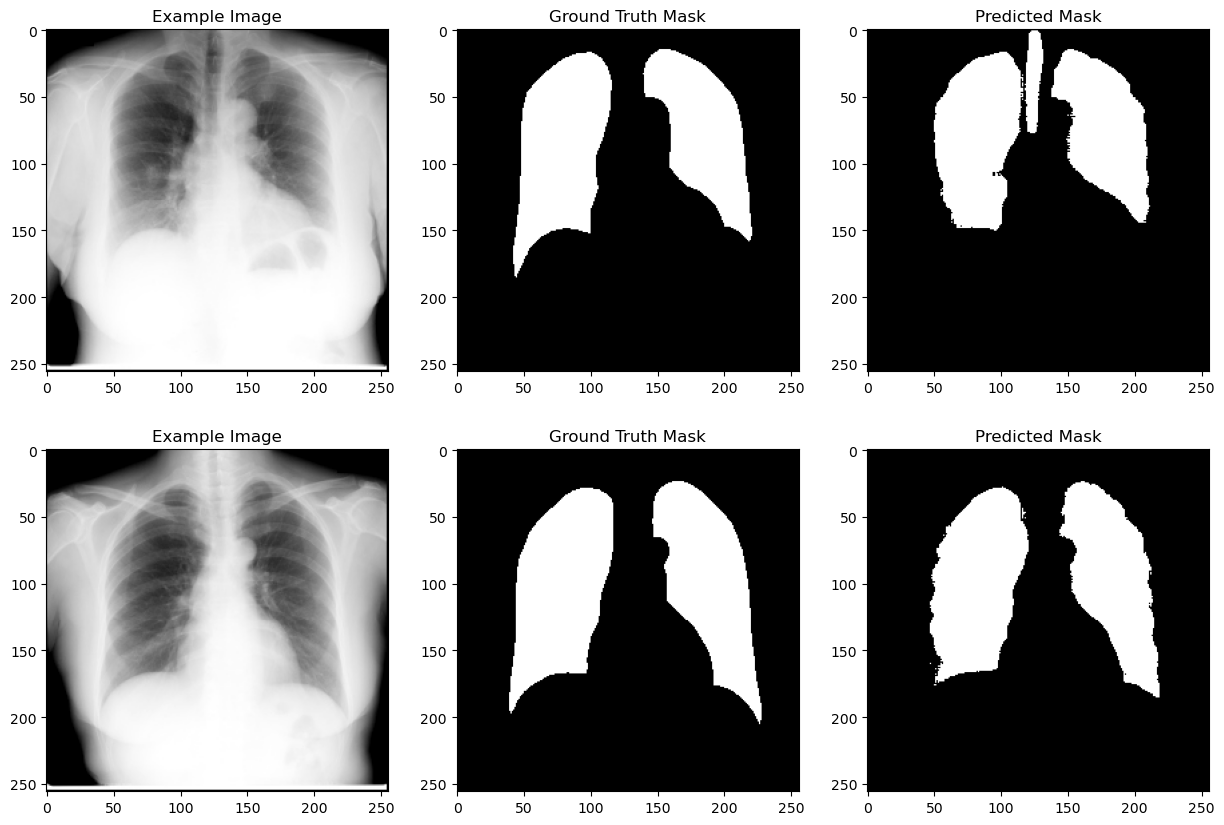

In [57]:
import torchmetrics
import numpy as np
import torch
f1 = torchmetrics.F1Score(task="binary")

f1_scores = []

input_points =  np.array([
    [70, 100], 
    [100, 50],
    [190, 100],
    [180, 70],
    [160, 150],
    [75,200],
    [125,200]
])

input_label = np.array([1, 1, 1, 1,0,0,0])


def predict_segmentation(img, input_points, input_label):
    predictor.set_image(img)

    masks, _, _ = predictor.predict(
        point_coords=input_points,
        point_labels=input_label,
        multimask_output=False
    )
    

    return masks[0]

for img, mask_gt in zip(x_val, y_val):

    predicted_mask = predict_segmentation(img, input_points, input_label)
    
    f1_score = f1(torch.tensor(predicted_mask), torch.tensor(mask_gt))
    f1_scores.append(f1_score.item())

mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

print(f"Mean F1 score: {mean_f1:.4f}")
print(f"Standard deviation: {std_f1:.4f}")

example_imgs = [x_val[0], x_val[1]]
example_masks_gt = [y_val[0], y_val[1]]
example_masks_pred = [predict_segmentation(x_val[0], input_points, input_label), 
                      predict_segmentation(x_val[1], input_points, input_label)]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i in range(2):
    axes[i, 0].imshow(example_imgs[i])
    axes[i, 0].set_title('Example Image')
    axes[i, 1].imshow(example_masks_gt[i], cmap='gray')
    axes[i, 1].set_title('Ground Truth Mask')
    axes[i, 2].imshow(example_masks_pred[i], cmap='gray')
    axes[i, 2].set_title('Predicted Mask')
plt.show()

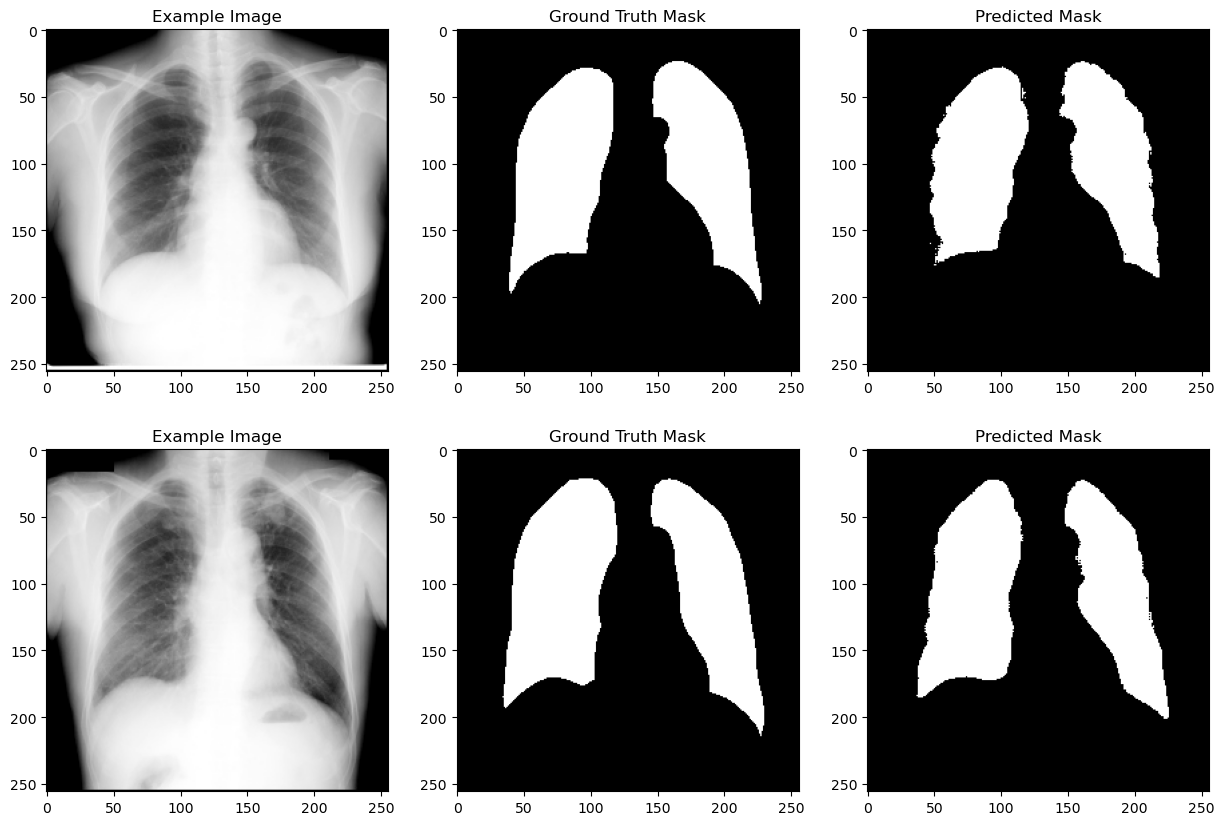

In [55]:
example_imgs = [x_val[1], x_val[2]]
example_masks_gt = [y_val[1], y_val[2]]
example_masks_pred = [predict_segmentation(x_val[1], input_points, input_label), 
                      predict_segmentation(x_val[2], input_points, input_label)]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i in range(2):
    axes[i, 0].imshow(example_imgs[i])
    axes[i, 0].set_title('Example Image')
    axes[i, 1].imshow(example_masks_gt[i], cmap='gray')
    axes[i, 1].set_title('Ground Truth Mask')
    axes[i, 2].imshow(example_masks_pred[i], cmap='gray')
    axes[i, 2].set_title('Predicted Mask')
plt.show()

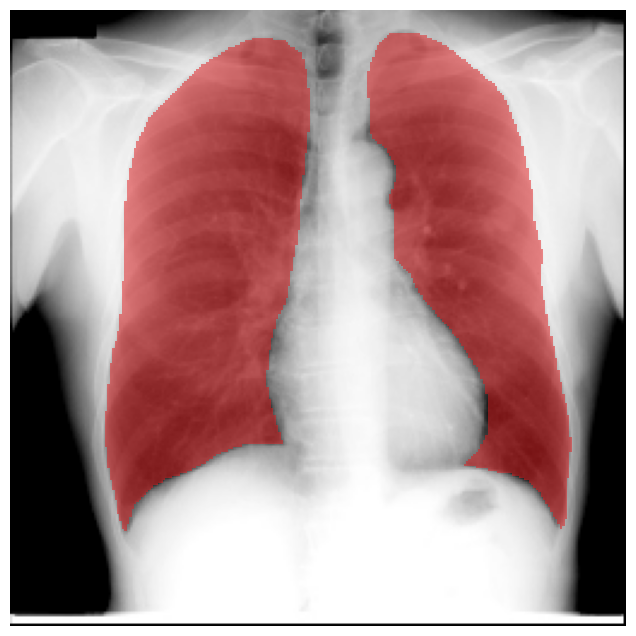

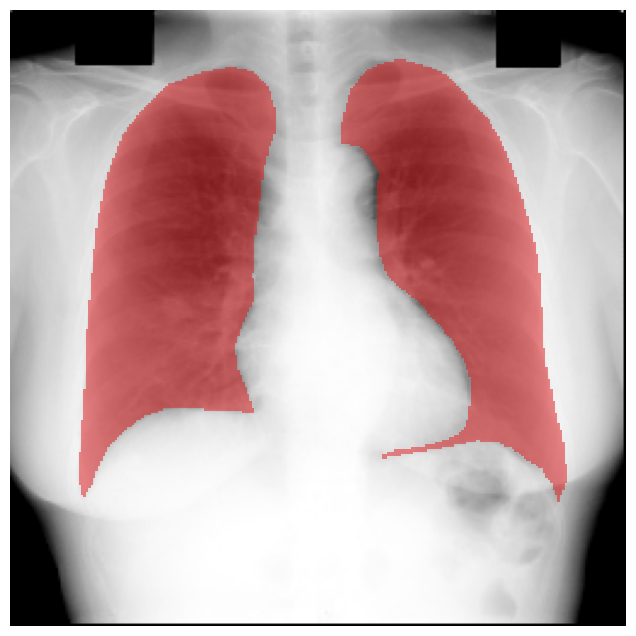

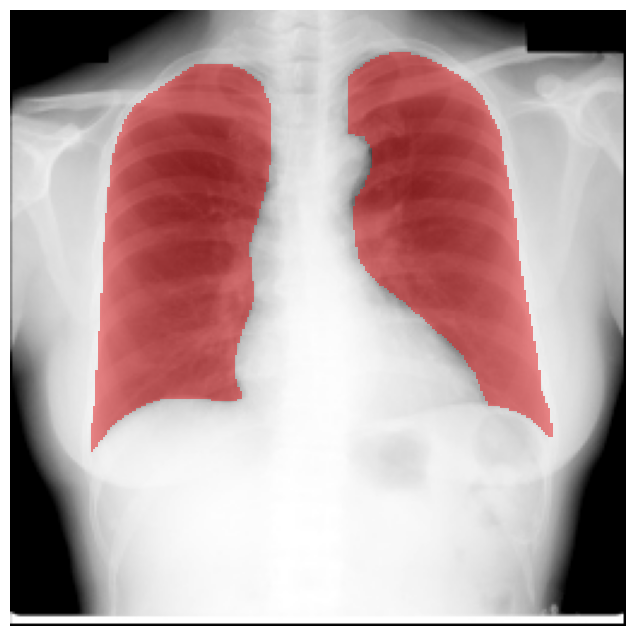

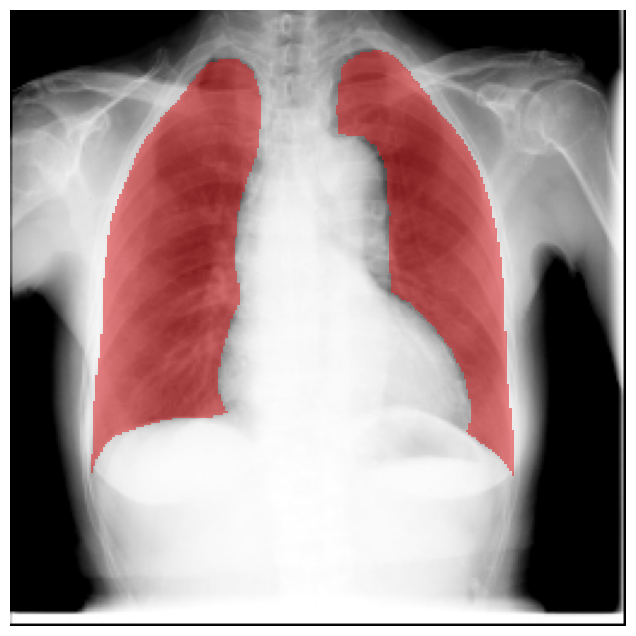

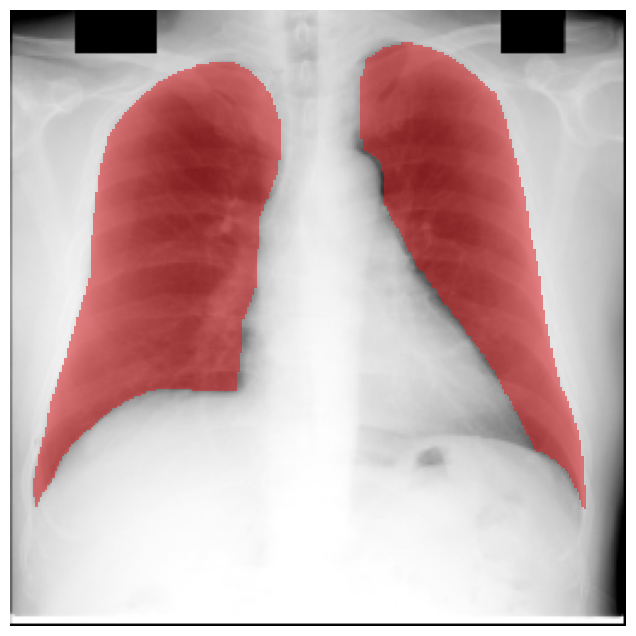

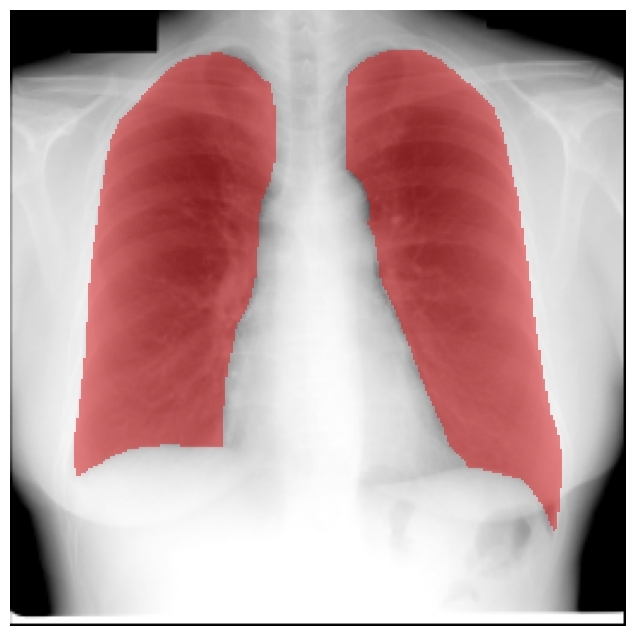

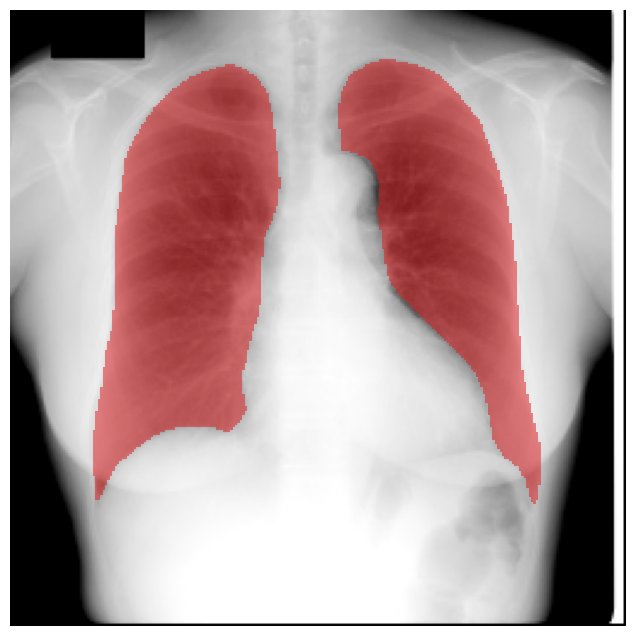

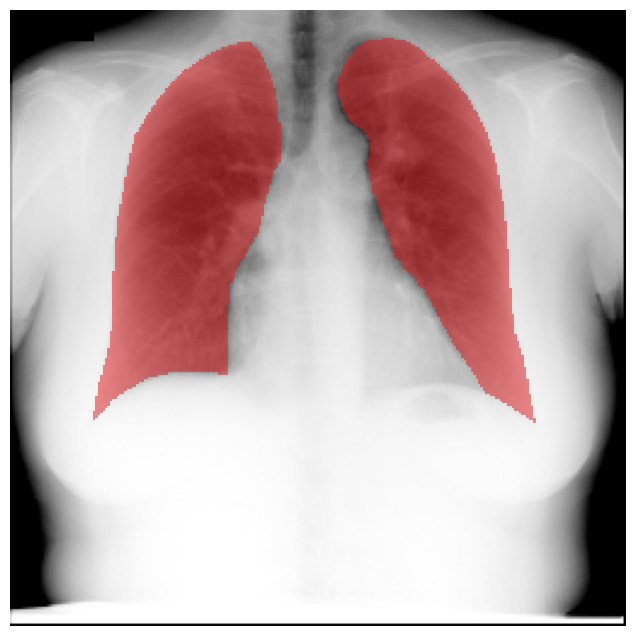

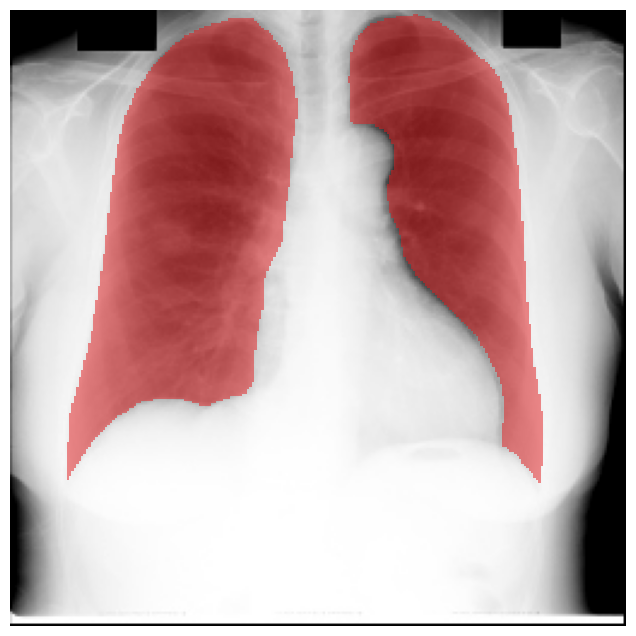

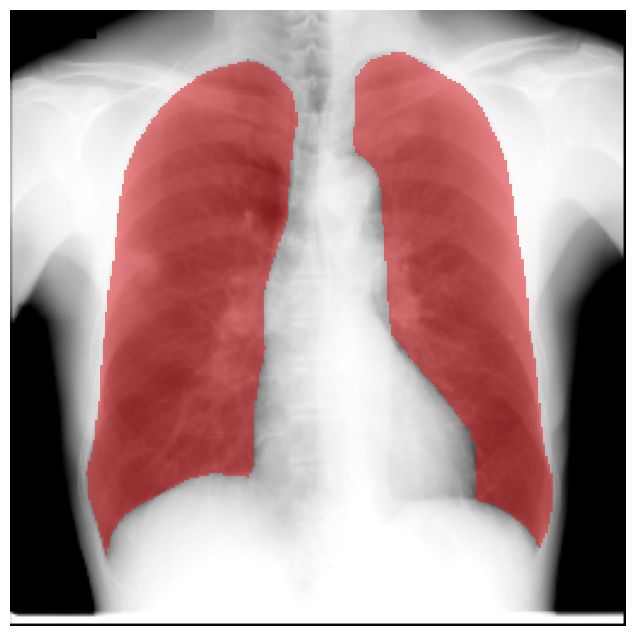

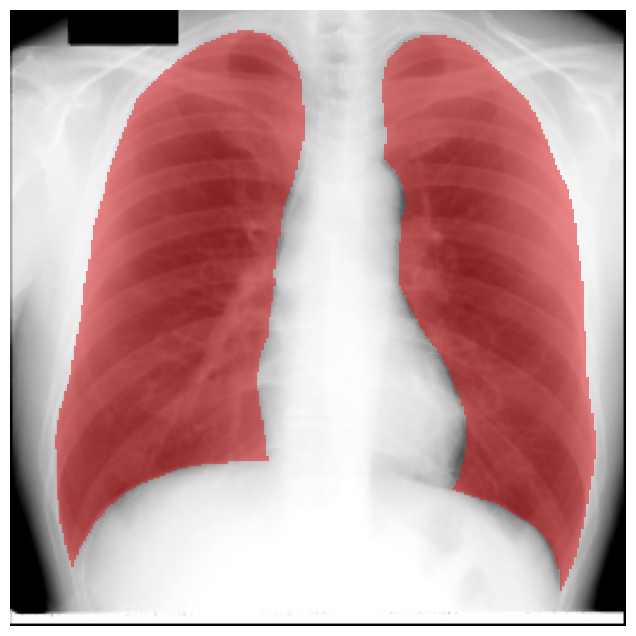

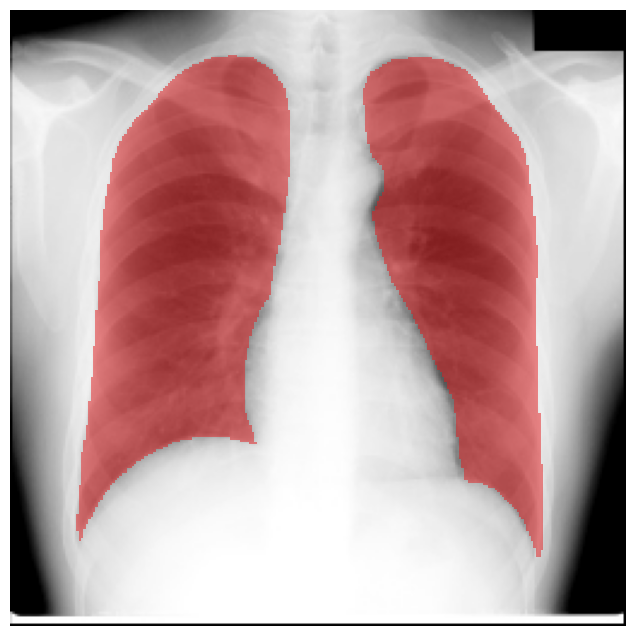

In [53]:
for i in range(12):
    fig, ax = plot_image_with_segmentation(x_train[i], y_train[i])
plt.show()
input_points =  np.array([
    [70, 100], 
    [100, 50],
    [190, 100],
    [180, 70],
    [160, 150],
    [75,200],
    [125,200]
])

input_label = np.array([1, 1, 1, 1,0,0,0])